# an analysis of the timing differences in VBA and SDK trials
We believe that visual_behavior_analysis is providing a reliable measure of the stimulus, lick and reward times, though it does not account for display lag. What follows is an analysis of the difference between timing in VBA and the SDK. Timing differences between the two should not exceed the display lag for a given session.

In [172]:
import pandas as pd
import visual_behavior.database as db
import numpy as np
import visual_behavior.utilities as vbu

from multiprocessing import Pool

from allensdk.brain_observatory.behavior.behavior_session import BehaviorSession
from allensdk.brain_observatory.behavior.behavior_ophys_session import BehaviorOphysSession
from visual_behavior.translator.foraging2 import data_to_change_detection_core

import matplotlib.pyplot as plt
import seaborn as sns

In [85]:
%matplotlib notebook

## a function to compare the lick/change and reward/change lags for each trial in both the SDK and VBA

In [2]:
def compare_trials(row, interface):
    '''
    compares entries in the trials dataframe from either the SDK or VBA
    '''
    if interface == 'sdk':
        value_dict = {
            'change_reward_lag': row['reward_time'] - row['change_time'] if row['reward_time'] and row['change_time'] else None,
            'change_lick_lag': row['lick_times'][0] - row['change_time'] if len(row['lick_times']) > 0 and row['change_time'] else None,
        }
    elif interface == 'vba':
        value_dict = {
            'change_reward_lag': row['reward_times'][0] - row['change_time'] if len(row['reward_times']) > 0 and row['change_time'] else None,
            'change_lick_lag': row['lick_times'][0] - row['change_time'] if len(row['lick_times']) > 0 and row['change_time'] else None,
        }

    return value_dict

## sql query to get behavior session ID given an ophys experiment id

In [3]:
def get_behavior_session_id_from_ophys_experiment_id(ophys_experiment_id):
    query = '''
        select bs.id
        from ophys_experiments as oe
        join ophys_sessions as os on oe.ophys_session_id = os.id
        join behavior_sessions as bs on os.foraging_id = bs.foraging_id
        where oe.id = {}
    '''
    return db.lims_query(query.format(ophys_experiment_id))

## convenience function to open a VBA core_data dictionary given a behavior session ID

In [4]:
def open_vba_session(behavior_session_id):
    pkl_path = db.get_pkl_path(behavior_session_id)
    data = pd.read_pickle(pkl_path)
    core_data = data_to_change_detection_core(data)
    return core_data

## function for comparing diffs across two packages
we would expect the change-lick or change-reward latency to be consistent in the SDK and VBA, within some tolerance. Since the SDK accounts for display lag but VBA does not, that tolerance should be no larger than the largest expected display lag. I'm setting it to 50 ms, even though the largest expected display lag is more likely 20-30 ms.

In [ ]:
## define a function to determine if columns in a given row are the same
def is_same(row, column_name, tolerance = 0.05):
    '''check if columns in a given row are the same'''
    # if column diff is not null, check if it is within tolerance
    if pd.notnull(row['{}_diff'.format(column_name)]):
        is_same = row['{}_diff'.format(column_name)] < tolerance
    # otherwise, ensure that both corresponding columns are null (one being null and the other having a value indicates a problem)
    else:
        is_same = pd.isnull(row['{}_sdk'.format(column_name)]) and pd.isnull(row['{}_vba'.format(column_name)])
    return is_same

## a function to compare each trial of a session from VBA and the SDK

In [31]:
def compare_vba_sdk_trials(behavior_session_id = None, ophys_experiment_id = None):
    
    ## open session with SDK (either BehaviorOphysSession or BehaviorSession)
    if ophys_experiment_id:
        session = BehaviorOphysSession.from_lims(ophys_experiment_id)
        # get the behavior session ID if the ophys session ID was passed
        behavior_session_id = get_behavior_session_id_from_ophys_experiment_id(ophys_experiment_id)
    elif behavior_session_id:
        session = BehaviorSession.from_lims(behavior_session_id)
    sdk_trials = session.trials

    # open vba session (aka 'core_data')
    core_data = open_vba_session(behavior_session_id)
    vba_trials = core_data['trials']

    # get values for both data types
    sdk_values = pd.DataFrame([compare_trials(row, interface='sdk') for idx, row in sdk_trials.iterrows()])
    vba_values = pd.DataFrame([compare_trials(row, interface='vba') for idx, row in vba_trials.iterrows()])

    # merge 'em together
    comparison_df = pd.merge(
        left = sdk_values,
        right = vba_values,
        left_index = True,
        right_index = True,
        suffixes = ['_sdk', '_vba']
    )
    
    # do comparison for each column type
    for column in sdk_values.columns:
        # get the diff
        comparison_df['{}_diff'.format(column)] = comparison_df['{}_sdk'.format(column)] - comparison_df['{}_vba'.format(column)]
        # check to see if diff matches
        comparison_df['{}_matches'.format(column)] = comparison_df.apply(is_same, column_name=column, axis=1)
        
    col_order = list(np.array([[col+'_sdk', col+'_vba', col+'_diff', col+'_matches'] for col in sdk_values.columns]).flatten())
    return comparison_df[col_order]

## a function to check if all booleans are True for the column ending in the string 'matches'
given the logic in `compare_vba_sdk_trials`, all booleans would be True if all trials matched within tolerance, or both were NaN (e.g., no licks or rewards on that trial)

In [32]:
def check_comparison(comparison_df):
    cols_to_check = [col for col in comparison_df.columns if col.endswith('matches')]
    return {col:comparison_df[col].all() for col in cols_to_check}

## use Pandas describe to get stats on a column everywhere that column is not NaN in VBA
In other words, for every column where VBA identifies a change-lick or change-reward interval, get stats on the diff of that interval between VBA and SDK

In [56]:
def describe_diff(comparison_df, comparison):
    return comparison_df[pd.notnull(comparison_df['{}_vba'.format(comparison)])]['{}_diff'.format(comparison)].describe()

## get a comparison df for two ophys experiments

In [50]:
comparison_df = compare_vba_sdk_trials(ophys_experiment_id = 877669819)
comparison_df[pd.notnull(comparison_df['change_reward_lag_vba'])]

/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
ERROR:visual_behavior.translator.foraging2.extract:intervalsms record appears to be missing entries


,change_reward_lag_sdk,change_reward_lag_vba,change_reward_lag_diff,change_reward_lag_matches,change_lick_lag_sdk,change_lick_lag_vba,change_lick_lag_diff,change_lick_lag_matches
0,0.097298,0.149410,0.052112,False,4.167687,4.219884,0.052197,False
4,0.097325,0.149440,0.052115,False,0.381268,0.433397,0.052129,False
11,0.097352,0.149432,0.052080,False,2.599733,2.651888,0.052155,False
15,0.097291,0.149327,0.052037,False,3.834081,3.886213,0.052132,False
17,0.114017,0.166141,0.052123,False,0.181116,0.233264,0.052148,False
...,...,...,...,...,...,...,...,...
386,0.331308,0.383555,0.052247,False,0.331009,0.383290,0.052280,False
389,0.348248,0.400567,0.052319,False,0.347735,0.400181,0.052446,False
393,0.414877,0.467127,0.052250,False,0.414378,0.466886,0.052508,False
396,0.264475,0.316838,0.052363,False,0.080806,0.133256,0.052450,False


In [60]:
comparison_df = compare_vba_sdk_trials(ophys_experiment_id = 986415685)
comparison_df[pd.notnull(comparison_df['change_reward_lag_vba'])]

/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()


,change_reward_lag_sdk,change_reward_lag_vba,change_reward_lag_diff,change_reward_lag_matches,change_lick_lag_sdk,change_lick_lag_vba,change_lick_lag_diff,change_lick_lag_matches
1,0.115671,0.151406,0.035735,True,0.378907,0.421858,0.042951,True
5,0.120014,0.155769,0.035755,True,0.378867,0.426210,0.047342,True
7,0.120645,0.156408,0.035763,True,0.328831,0.376849,0.048017,True
14,0.113883,0.149651,0.035767,True,0.378860,0.425978,0.047118,True
15,0.113893,0.149765,0.035872,True,0.345494,0.390205,0.044711,True
28,0.185172,0.220992,0.035820,True,0.178679,0.220906,0.042227,True
96,0.654608,0.690481,0.035873,True,0.645665,0.690379,0.044714,True
177,0.407315,0.443270,0.035954,True,0.395486,0.443172,0.047685,True
294,0.673052,0.709044,0.035992,True,0.662357,0.708942,0.046585,True
329,0.300064,0.335895,0.035831,True,0.295411,0.335791,0.040380,True


## a function to get diff stats for a given ophys experiment

In [76]:
def get_diff_stats(ophys_experiment_id):
    try:
        session = BehaviorOphysSession.from_lims(ophys_experiment_id)
        comparison_df = compare_vba_sdk_trials(ophys_experiment_id=ophys_experiment_id)
        out_dict = {
            'ophys_experiment_id': ophys_experiment_id,
            'min_stim_timestamp': session.stimulus_timestamps.min(),
            'reward_diff_mean': describe_diff(comparison_df, 'change_reward_lag')['mean'],
            'reward_diff_std': describe_diff(comparison_df, 'change_reward_lag')['std'],
            'reward_diff_count': describe_diff(comparison_df, 'change_reward_lag')['count'],
            'lick_diff_mean': describe_diff(comparison_df, 'change_lick_lag')['mean'],
            'lick_diff_std': describe_diff(comparison_df, 'change_lick_lag')['std'],
            'lick_diff_count': describe_diff(comparison_df, 'change_lick_lag')['count'],
        }
    except:
        out_dict = {
            'ophys_experiment_id': None,
            'min_stim_timestamp': None,
            'reward_diff_mean': None,
            'reward_diff_std': None,
            'reward_diff_count':None,
            'lick_diff_mean': None,
            'lick_diff_std': None,
            'lick_diff_count': None,
        }
    return out_dict

## get diff stats for a sample of ophys experiments

In [92]:
et = loading.get_filtered_ophys_experiment_table()
et_sample = et.sample(500, random_state=0)
with Pool(32) as pool:
    diff_stats = pd.DataFrame(pool.map(get_diff_stats, et_sample.index.values))

/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observa

/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observa

/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observa

/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observa

/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observa

/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
ERROR:visual_behavior.translator.foraging2.extract:intervalsms record appears to be m

/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observa

ERROR:visual_behavior.translator.foraging2.extract:intervalsms record appears to be missing entries
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check

/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observa

/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observa

/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observa

/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observa

ERROR:visual_behavior.translator.foraging2.extract:intervalsms record appears to be missing entries
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
ERROR:visual_behavior.translator.foraging2.extract:intervalsms record appears to be missing entries
ERROR:visual_behavior.translator.foraging2.extract:intervalsms record appears to be missing entries
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/

/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
ERROR:visual_behavior.translator.foraging2.extract:intervalsms record appears to be missing entries
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check

/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observa

/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observa

/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
ERROR:visual_behavior.translator.foraging2.extract:intervalsms record appears to be missing entries
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check

/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observa

ERROR:visual_behavior.translator.foraging2.extract:intervalsms record appears to be missing entries
ERROR:visual_behavior.translator.foraging2.extract:intervalsms record appears to be missing entries
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label 

/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
ERROR:visual_behavior.translator.foraging2.extract:intervalsms record appears to be missing entries
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check

/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observa

/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
ERROR:visual_behavior.translator.foraging2.extract:intervalsms record appears to be missing entries
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check

/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
ERROR:visual_behavior.translator.foraging2.extract:intervalsms record appears to be missing entries
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check

/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
ERROR:visual_behavior.translator.foraging2.extract:intervalsms record appears to be missing entries
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check

ERROR:visual_behavior.translator.foraging2.extract:intervalsms record appears to be missing entries
ERROR:visual_behavior.translator.foraging2.extract:intervalsms record appears to be missing entries
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label 

/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observa

/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
ERROR:visual_behavior.translator.foraging2.extract:intervalsms record appears to be missing entries
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check

ERROR:visual_behavior.translator.foraging2.extract:intervalsms record appears to be missing entries
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check

/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observa

/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'eye_tracking', 'behavior_monitoring'}. Consider updating the sync file line labels.
  self._check_line_labels()
ERROR:visual_behavior.translator.foraging2.extract:intervalsms record appears to be missing entries
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._

/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
ERROR:visual_behavior.translator.foraging2.extract:intervalsms record appears to be missing entries
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check

ERROR:visual_behavior.translator.foraging2.extract:intervalsms record appears to be missing entries
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check

ERROR:visual_behavior.translator.foraging2.extract:intervalsms record appears to be missing entries
ERROR:visual_behavior.translator.foraging2.extract:intervalsms record appears to be missing entries
ERROR:visual_behavior.translator.foraging2.extract:intervalsms record appears to be missing entries
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/

/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
ERROR:visual_behavior.translator.foraging2.extract:intervalsms record appears to be missing entries
ERROR:visual_behavior.translator.foraging2.extract:intervalsms record appears to be missing entries
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label 

/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observa

/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observa

ERROR:visual_behavior.translator.foraging2.extract:intervalsms record appears to be missing entries
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check

/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observa

/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
ERROR:visual_behavior.translator.foraging2.extract:intervalsms record appears to be missing entries
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check

/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observa

ERROR:visual_behavior.translator.foraging2.extract:intervalsms record appears to be missing entries
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check

/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
ERROR:visual_behavior.translator.foraging2.extract:intervalsms record appears to be missing entries
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check

/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
ERROR:visual_behavior.translator.foraging2.extract:intervalsms record appears to be m

/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observa

/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observa

ERROR:visual_behavior.translator.foraging2.extract:intervalsms record appears to be missing entries
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
ERROR:visual_behavior.translator.foraging2.extract:intervalsms record appears to be missing entries
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label 

/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
ERROR:visual_behavior.translator.foraging2.extract:intervalsms record appears to be m

/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'eye_tracking', 'behavior_monitoring'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
CRITICAL:visual_behavior.translator.foraging2:Image file not found: //allen/prog

ERROR:visual_behavior.translator.foraging2.extract:intervalsms record appears to be missing entries
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check

CRITICAL:visual_behavior.translator.foraging2:Image file not found: //allen/programs/braintv/workgroups/nc-ophys/Doug/Stimulus_Code/image_dictionaries/Natural_Images_Lum_Matched_set_TRAINING_2017.07.14.pkl
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line 

ERROR:visual_behavior.translator.foraging2.extract:intervalsms record appears to be missing entries
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check

/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observa

ERROR:visual_behavior.translator.foraging2.extract:intervalsms record appears to be missing entries
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
ERROR:visual_behavior.translator.foraging2.extract:intervalsms record appears to be missing entries
ERROR:visual_behavior.translator.foraging2.extract:intervalsms record appears to be missing entries
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
ERROR:visual_behavior.translator.foraging2.extract:intervalsms record appears to be missin

/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
ERROR:visual_behavior.translator.foraging2.extract:intervalsms record appears to be missing entries
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check

/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'eye_tracking', 'behavior_monitoring'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_ob

/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observa

ERROR:visual_behavior.translator.foraging2.extract:intervalsms record appears to be missing entries
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check

/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observa

/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observa

/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observa

/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
ERROR:visual_behavior.translator.foraging2.extract:intervalsms record appears to be missing entries
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check

/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
ERROR:visual_behavior.translator.foraging2.extract:intervalsms record appears to be missing entries
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check

/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
ERROR:visual_behavior.translator.foraging2.extract:intervalsms record appears to be m

/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observa

/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
ERROR:visual_behavior.translator.foraging2.extract:intervalsms record appears to be missing entries
ERROR:visual_behavior.translator.foraging2.extract:intervalsms record appears to be missing entries
ERROR:visual_behavior.translator.foraging2.extract:intervalsms record appears to be missing entries
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/

/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observa

/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observa

ERROR:visual_behavior.translator.foraging2.extract:intervalsms record appears to be missing entries
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
ERROR:visual_behavior.translator.foraging2.extract:intervalsms record appears to be missing entries
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label 

/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observa

/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
ERROR:visual_behavior.translator.foraging2.extract:intervalsms record appears to be m

/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
ERROR:visual_behavior.translator.foraging2.extract:intervalsms record appears to be m

ERROR:visual_behavior.translator.foraging2.extract:intervalsms record appears to be missing entries
ERROR:visual_behavior.translator.foraging2.extract:intervalsms record appears to be missing entries
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
ERROR:visual_behavior.translator.foraging2.extract:intervalsms record appears to be missing entries
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/

/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
ERROR:visual_behavior.translator.foraging2.extract:intervalsms record appears to be m

In [93]:
diff_stats.dropna()

,ophys_experiment_id,min_stim_timestamp,reward_diff_mean,reward_diff_std,reward_diff_count,lick_diff_mean,lick_diff_std,lick_diff_count
1,9.140625e+08,6.328934,0.037096,0.000067,35.0,0.043661,0.002820,100.0
2,9.512132e+08,9.043991,0.052368,0.000069,91.0,0.052641,0.000125,148.0
5,8.755875e+08,9.916008,0.044314,0.000044,62.0,0.052380,0.000227,76.0
9,1.051460e+09,9.718861,0.097877,0.000052,73.0,0.052895,0.000134,98.0
12,9.577596e+08,8.777328,0.052299,0.000071,75.0,0.052671,0.000159,92.0
...,...,...,...,...,...,...,...,...
495,8.897717e+08,7.519670,0.028646,0.000299,120.0,0.043578,0.002850,167.0
496,9.241989e+08,7.339803,0.052513,0.000065,81.0,0.052676,0.001713,92.0
497,1.052638e+09,9.030742,0.097149,0.000109,80.0,0.110849,0.638792,122.0
498,9.756084e+08,9.175346,0.052543,0.000062,60.0,0.052657,0.000173,122.0


## the diffs are very consistent within session, but wildly variable across sessions. Why?

<IPython.core.display.Javascript object>


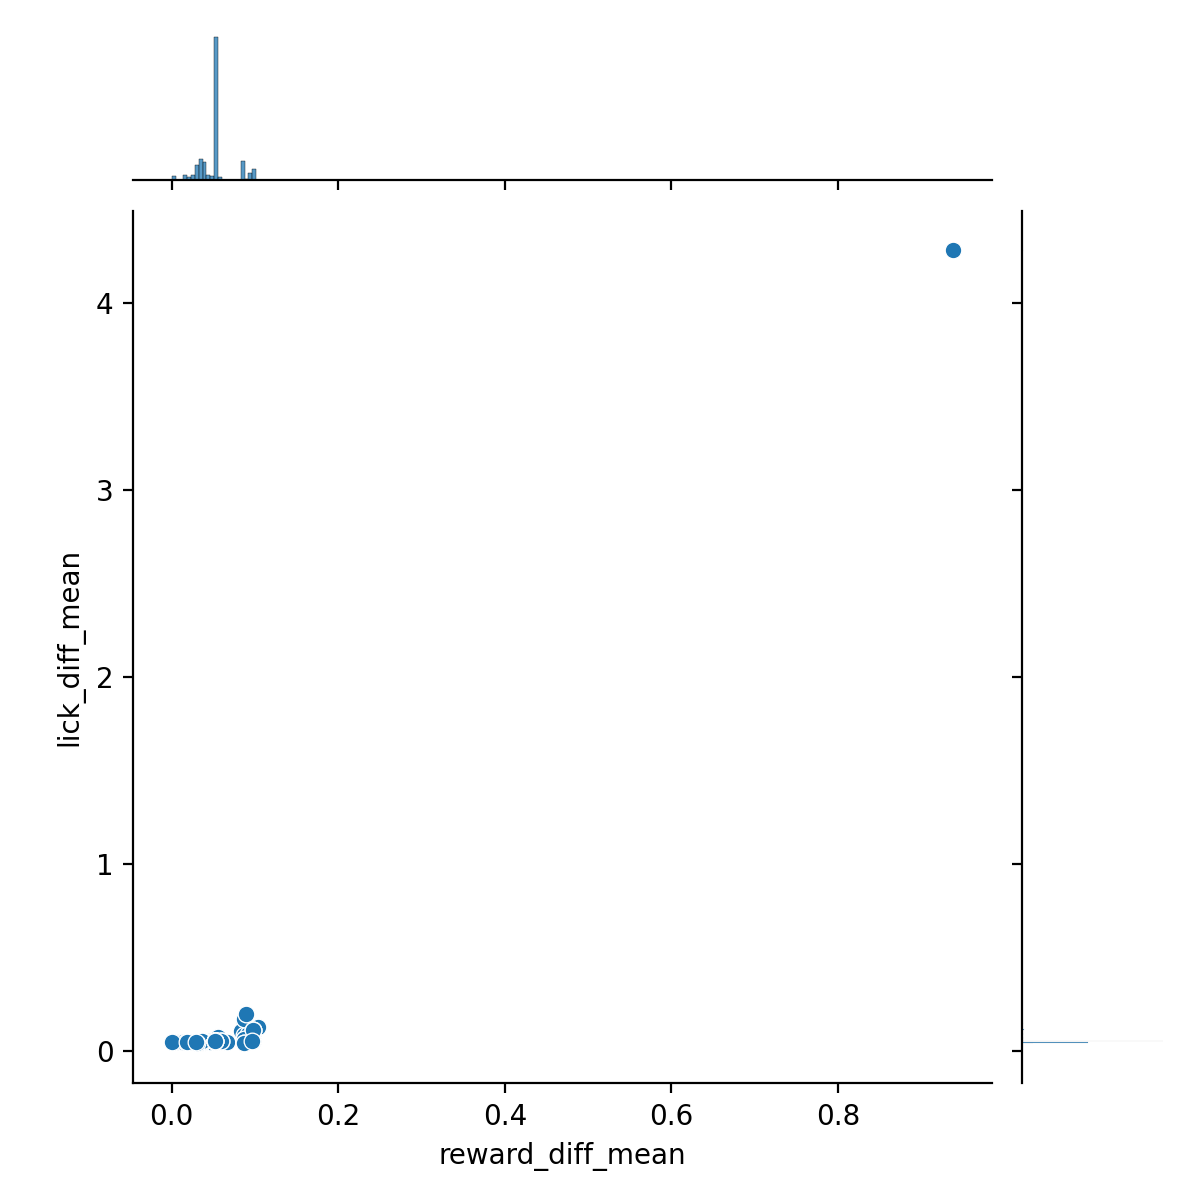

In [97]:
sns.jointplot(
    data = diff_stats,
    x = 'reward_diff_mean',
    y = 'lick_diff_mean',
)

In [95]:
diff_stats['reward_diff_mean'].describe()

count    296.000000
mean       0.054797
std        0.055386
min        0.000224
25%        0.037157
50%        0.052336
75%        0.052547
max        0.938161
Name: reward_diff_mean, dtype: float64

In [96]:
diff_stats['lick_diff_mean'].describe()

count    296.000000
mean       0.066624
std        0.246501
min        0.037562
25%        0.044032
50%        0.052429
75%        0.052690
max        4.284318
Name: lick_diff_mean, dtype: float64

## pick one trial in one session, drill in

In [144]:
ophys_experiment_id = diff_stats.dropna().sort_values(by='reward_diff_mean').iloc[-1]['ophys_experiment_id']
ophys_experiment_id

856938751.0

In [194]:
core_data = open_vba_session(get_behavior_session_id_from_ophys_experiment_id(ophys_experiment_id))
from visual_behavior.translator.core import create_extended_dataframe

extended_trials = create_extended_dataframe(**core_data)

### I'm choosing trial 34 since it has a reward

In [196]:
vba_trial = extended_trials.iloc[34]
vba_trial.to_dict()

{'index': 34,
 'lick_times': [456.022662262943,
  456.1227594830562,
  456.3729323171879,
  456.4896944631924,
  456.58977793264296,
  456.72322051060536,
  456.8566619182987,
  456.9734398629373,
  457.10686751996786,
  457.2570063285227,
  457.3904491990526,
  457.54057250154034,
  457.69069463375905,
  457.82413662658695,
  457.9575484849833,
  458.10768670840343,
  458.24111641340505,
  458.37458941836667,
  458.5413776467458],
 'auto_rewarded': False,
 'cumulative_volume': 0.039,
 'cumulative_reward_number': 7,
 'reward_volume': 0.007,
 'reward_times': array([456.02266226]),
 'reward_frames': [27337],
 'rewarded': True,
 'optogenetics': False,
 'response_type': 'HIT',
 'response_time': [],
 'response_latency': 0.6338529035988358,
 'change_frame': 27299.0,
 'change_time': 455.3888093593442,
 'starttime': 452.3863362879701,
 'startframe': 27119,
 'trial_length': 7.506169805474883,
 'scheduled_change_time': 4.0,
 'endtime': 459.89248298062773,
 'endframe': 27569,
 'initial_image_cate

In [200]:
core_data['licks'].query('time > 455').iloc[:20]

,frame,time
201,27337,456.022662
202,27343,456.122759
203,27358,456.372932
204,27365,456.489694
205,27371,456.589778
206,27379,456.723221
207,27387,456.856662
208,27394,456.973440
209,27402,457.106868
210,27411,457.257006


In [197]:
vba_change_time = core_data['time'][int(vba_trial['change_frame'])]
vba_change_time

455.3888093593442

In [198]:
vba_reward_time = core_data['time'][int(vba_trial['reward_frames'][0])]
vba_reward_time

456.022662262943

In [199]:
vba_reward_time - vba_change_time

0.6338529035988358

#### this SDK trial is completely wrong! The reward and the first lick are both before the change!!! That is not possible!!!!

In [135]:
sdk_session = BehaviorOphysSession.from_lims(ophys_experiment_id)
sdk_trial = sdk_session.trials.iloc[34]

/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()


In [143]:
sdk_trial

lick_times            [459.18050430728715, 459.33064038511617, 463.6...
reward_time                                                     462.756
reward_volume                                                     0.007
hit                                                                True
false_alarm                                                       False
miss                                                              False
stimulus_change                                                    True
aborted                                                           False
go                                                                 True
catch                                                             False
auto_rewarded                                                     False
correct_reject                                                    False
start_time                                                      459.114
stop_time                                                       

In [139]:
sdk_change_time = sdk_trial['change_time']
sdk_change_time

463.0552178878255

In [141]:
sdk_reward_time = sdk_trial['reward_time']
sdk_reward_time

462.75602413647255

In [142]:
sdk_reward_time - sdk_change_time

-0.2991937513529592

In [177]:
sdk_trial[['change_time', 'change_frame', 'reward_time', 'lick_times']]

change_time                                               463.055
change_frame                                                27299
reward_time                                               462.756
lick_times      [459.18050430728715, 459.33064038511617, 463.6...
Name: 34, dtype: object

In [145]:
comparison_df = compare_vba_sdk_trials(ophys_experiment_id=856938751)

/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()


In [147]:
comparison_df[pd.notnull(comparison_df['change_reward_lag_sdk'])]

,change_reward_lag_sdk,change_reward_lag_vba,change_reward_lag_diff,change_reward_lag_matches,change_lick_lag_sdk,change_lick_lag_vba,change_lick_lag_diff,change_lick_lag_matches
7,-0.772047,0.166107,0.938153,False,-3.841337,0.660545,4.501882,False
16,-0.781186,0.156915,0.938101,False,-4.525216,0.507632,5.032848,False
21,-0.787457,0.150699,0.938156,False,-6.626951,0.571181,7.198131,False
23,-0.786825,0.151306,0.938131,False,-4.491869,0.651892,5.143761,False
26,-0.783052,0.154937,0.937989,False,-5.408983,0.055655,5.464637,False
...,...,...,...,...,...,...,...,...
593,-0.344412,0.593754,0.938166,False,-5.359284,0.593506,5.952790,False
601,-0.248398,0.689675,0.938073,False,-6.777084,0.689538,7.466622,False
613,-0.215428,0.722759,0.938187,False,0.679000,0.722624,0.043624,True
634,-0.203300,0.734882,0.938181,False,-5.342217,0.734740,6.076957,False


In [175]:
sdk_session.stimulus_presentations.query('start_frame >= 27299').iloc[:5][['start_frame','start_time']]

,start_frame,start_time
stimulus_presentations_id,,
207,27300,463.055218
208,27345,463.805828
209,27390,464.556448
210,27435,465.307048
211,27480,466.057658


In [184]:
sdk_session.rewards.reset_index().query('timestamps >= 450').iloc[:5]

,timestamps,volume,autorewarded
6,462.756024,0.007,False
7,497.265301,0.007,False
8,514.995014,0.007,False
9,532.584717,0.007,False
10,569.364399,0.007,False


In [189]:
sdk_session.licks.query('time >= 450').iloc[:10]

,time
195,454.160108
196,454.359933
197,458.863609
198,459.030409
199,459.180504
200,459.330640
201,463.650848
202,463.750945
203,464.001117
204,464.117879


In [201]:
sdk_session.stimulus_timestamps[27337]

463.6723878878255